In [2]:
import argparse
import json
import logging
import pickle
import wandb
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
import os
import numpy as np
import copy

In [3]:
import matplotlib
matplotlib.rcParams.update(
    {
        "figure.dpi": 150,
        "font.size": 14,
        "figure.figsize": (7.5, 4.8)
    }
)
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [4]:
api = wandb.Api(timeout=200)

In [5]:
SMOOTH_WINDOW = 30


def smooth(to_smooth, window_size=SMOOTH_WINDOW):
    smoothed = []
    for idx, val in enumerate(to_smooth):
        if idx < window_size:
            smoothed.append(np.mean(to_smooth[: idx + 1]))
        else:
            smoothed.append(np.mean(to_smooth[idx - (SMOOTH_WINDOW - 1) : idx + 1]))

    return np.array(smoothed)

In [21]:
def load_groups(group_and_keys, relabel_dict, x_range, extra_filter):
    all_interp_data = []
    for group, x_key, y_key in group_and_keys:
        runs = api.runs(
            path="resl-mixppo/stabilized-rl",
            filters={
                "$and": [
                    {"group": group},
                    {"$not": {"tags": "exclude-from-paper"}},
                    extra_filter,
                ]
            },
        )
        print(f"Got {len(runs)} runs for group {group}")
        x_vals = np.linspace(x_range[0], x_range[1], 1000)
        for r in tqdm(runs):
            # h = r.history(samples=2000, keys=[x_key, y_key])
            h = pd.DataFrame(r.scan_history(keys=[x_key, y_key]))
            try:
                if np.max(h[x_key]) < 0.99 * x_range[1]:
                    print("Maximum x value of run", str(r), "is", np.max(h[x_key]))
                # interp_y = np.interp(x_vals, h[x_key], smooth(h[y_key], 5))
                interp_y = np.interp(x_vals, h[x_key],h[y_key])
            except KeyError:
                print("Could not get keys in run", r)
            else:
                env = r.config['env']
                all_interp_data.append(
                    pd.DataFrame.from_dict(
                        {
                            relabel_dict.get(x_key, x_key): x_vals,
                            relabel_dict.get(y_key, y_key): interp_y,
                            relabel_dict.get("group", "group"): relabel_dict.get(
                                group, group
                            ),
                            "run": str(r),
                            relabel_dict.get("env", "env"): relabel_dict.get(
                                env, env
                            ),
                        }
                    )
                )
    return pd.concat(all_interp_data, ignore_index=True)

In [7]:
relabels = {
    "xppo-512-5": "xPPO",
    "baseline_ppo": "PPO-clip",
    "xppo10m-512-5": "xPPO",
    "basline_ppo_10m": "PPO-clip",
    "xppo_single_step_4096": "xPPO $|D_{h}|=32000$",
    "basline_stbl_ppo": "PPO-clip 4096",
    'xppo_single_step_large_historic': "xPPO $|D_{h}|=128000$",
    "xppo_single_step_no_historic": "xPPO $|D_{h}|=4096$",
    "global_step": "Total Environment Steps",
    "rollout/ep_rew_mean": "Average Episode Reward",
    "group": "Algorithm",
    'env': "Environment",
    'rollout/SuccessRate':'Average Success Rate',
    'train/std': "Action Distribution STD",
    "<SawyerPushEnvV2 instance>":"push",
    "<SawyerWindowCloseEnvV2 instance>":"window-close",
    "<SawyerDoorEnvV2 instance>":"door-open",
    "<SawyerReachEnvV2 instance>":"reach",
    "<SawyerButtonPressTopdownEnvV2 instance>":"button-press-topdown",
    "<SawyerWindowOpenEnvV2 instance>":"window-open",
    "<SawyerDrawerOpenEnvV2 instance>":"drawer-open",
    "<SawyerPegInsertionSideEnvV2 instance>":"peg-insert-side",
    "<SawyerDrawerCloseEnvV2 instance>":"drawer-close",
}
envs = ["<SawyerPushEnvV2 instance>",
"<SawyerWindowCloseEnvV2 instance>",
"<SawyerDoorEnvV2 instance>",
"<SawyerReachEnvV2 instance>",
"<SawyerButtonPressTopdownEnvV2 instance>",
"<SawyerPickPlaceEnvV2 instance>",
"<SawyerWindowOpenEnvV2 instance>",
"<SawyerDrawerOpenEnvV2 instance>",
"<SawyerPegInsertionSideEnvV2 instance>",
"<SawyerDrawerCloseEnvV2 instance>",]

## Pick-Place

In [22]:

env = "PickPlace-V2"
config_env = "<SawyerPickPlaceEnvV2 instance>"
total_steps=20e6
group_and_keys = [
    ("xppo_single_step_4096", "global_step",  "rollout/SuccessRate"),
    ("xppo_single_step_large_historic", "global_step", "rollout/SuccessRate"),
    ('xppo_single_step_no_historic', "global_step", "rollout/SuccessRate"),
    ("basline_stbl_ppo", "global_step", "rollout/SuccessRate"),
]
tag_filter = {"tags": {"$in": ["stbl_ppo_pick-place_baseline"]}}

# Don't add baseline_stbl_ppo as a group, that mixes the batch_size 50k v/s default size
group_filter = {"group": {"$in": ["xppo_single_step_4096", "xppo_single_step_large_historic", 'xppo_single_step_no_historic']}} # to not exclude not yet tagged runs
env_filter = {"config.env":config_env}
or_filter = {"$or": [tag_filter, {"$and": [group_filter,env_filter]}]}
# state_filter = {"$or": [{"state": "finished"}, {"state": "running"}]}
state_filter = {"$or": [{"state": "finished"}, {"state": "running"}]}



extra_filter = {'$and': [ state_filter, or_filter]}
all_data = load_groups(
    group_and_keys,
    relabels,
    (0, total_steps),
    extra_filter
)

Got 27 runs for group xppo_single_step_4096


  4%|▎         | 1/27 [00:00<00:06,  4.22it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/29264ow5 (running)> is 1961984


  7%|▋         | 2/27 [00:00<00:07,  3.46it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/uxiwyjad (running)> is 2588672


 11%|█         | 3/27 [00:01<00:08,  2.76it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/n5ufsw0a (running)> is 4681728


 15%|█▍        | 4/27 [00:01<00:09,  2.36it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/yaeo91wl (running)> is 5287936


 19%|█▊        | 5/27 [00:01<00:08,  2.72it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/t5mb0mda (running)> is 3067904


 22%|██▏       | 6/27 [00:02<00:07,  2.78it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/4qfyp0b6 (crashed)> is 7639040


 26%|██▌       | 7/27 [00:02<00:08,  2.34it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/et13d0zn (crashed)> is 16216064


 30%|██▉       | 8/27 [00:03<00:08,  2.14it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/l0cxktwo (crashed)> is 14188544


 33%|███▎      | 9/27 [00:03<00:06,  2.59it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/f1b3m8fa (crashed)> is 2007040


 37%|███▋      | 10/27 [00:03<00:07,  2.37it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/hg8c3riz (crashed)> is 12361728.0


 41%|████      | 11/27 [00:04<00:07,  2.22it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/exprsw2r (crashed)> is 14188544


 44%|████▍     | 12/27 [00:04<00:05,  2.67it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/487nohxq (crashed)> is 2887680.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/qf6le5d4 (crashed)> is 3559424.0


 56%|█████▌    | 15/27 [00:05<00:03,  3.88it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/vxk7e1x0 (crashed)> is 3108864.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/y8jogygw (crashed)> is 3035136.0


 63%|██████▎   | 17/27 [00:05<00:02,  4.14it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/94j2kfqa (failed)> is 4501504.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/g8hcvjc4 (crashed)> is 3301376.0


 67%|██████▋   | 18/27 [00:05<00:02,  4.38it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/8ai202s5 (crashed)> is 3579904.0


 70%|███████   | 19/27 [00:06<00:01,  4.09it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/5klq4eha (failed)> is 5062656.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/819azy46 (crashed)> is 3035136.0


 78%|███████▊  | 21/27 [00:06<00:01,  4.48it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/2q1gj4ss (crashed)> is 3534848.0


 81%|████████▏ | 22/27 [00:06<00:01,  3.96it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/zsxvwuk0 (failed)> is 4759552.0


 85%|████████▌ | 23/27 [00:07<00:01,  3.81it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/ggwvjzki (crashed)> is 4276224.0


 93%|█████████▎| 25/27 [00:07<00:00,  4.08it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/o7z6u27e (crashed)> is 4292608.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/0qn5yga5 (crashed)> is 2375680.0


100%|██████████| 27/27 [00:08<00:00,  3.34it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/nbpga08k (crashed)> is 2854912.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/zr67jhku (killed)> is 253952


Got 8 runs for group xppo_single_step_large_historic


 12%|█▎        | 1/8 [00:00<00:01,  4.06it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/tnq8pftz (running)> is 1269760


 25%|██▌       | 2/8 [00:00<00:01,  4.27it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/61h0u3u8 (running)> is 1224704


 38%|███▊      | 3/8 [00:00<00:01,  4.25it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/w21bewm0 (running)> is 1261568


 50%|█████     | 4/8 [00:00<00:00,  4.33it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/ipzu33hh (running)> is 942080


 62%|██████▎   | 5/8 [00:01<00:00,  4.36it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/fg8yx6tl (running)> is 2084864


 75%|███████▌  | 6/8 [00:01<00:00,  4.32it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/o0f7i71j (running)> is 1224704


 88%|████████▊ | 7/8 [00:01<00:00,  4.29it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/j1j6qih0 (running)> is 1822720


100%|██████████| 8/8 [00:01<00:00,  4.28it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/zpxvhvwn (running)> is 2068480


Got 10 runs for group xppo_single_step_no_historic


 10%|█         | 1/10 [00:00<00:01,  5.77it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/flpwudfb (crashed)> is 12288


 20%|██        | 2/10 [00:00<00:01,  5.68it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/mu4w4ja4 (crashed)> is 3551232.0


 30%|███       | 3/10 [00:00<00:01,  5.50it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/eleawdrb (crashed)> is 3956736.0


 40%|████      | 4/10 [00:00<00:01,  5.59it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/jxrf3xo0 (crashed)> is 3411968.0


 50%|█████     | 5/10 [00:00<00:01,  4.60it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/1wvwx056 (failed)> is 7495680


 70%|███████   | 7/10 [00:01<00:00,  4.57it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/0dronzqi (crashed)> is 4362240.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/x02ml9bi (killed)> is 520192


 80%|████████  | 8/10 [00:01<00:00,  4.65it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/lyt43hm3 (killed)> is 1236992.0


100%|██████████| 10/10 [00:02<00:00,  4.85it/s]

Maximum x value of run <Run resl-mixppo/stabilized-rl/nj38qvss (killed)> is 1699840.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/ejyur405 (killed)> is 696320


Got 3 runs for group basline_stbl_ppo


100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


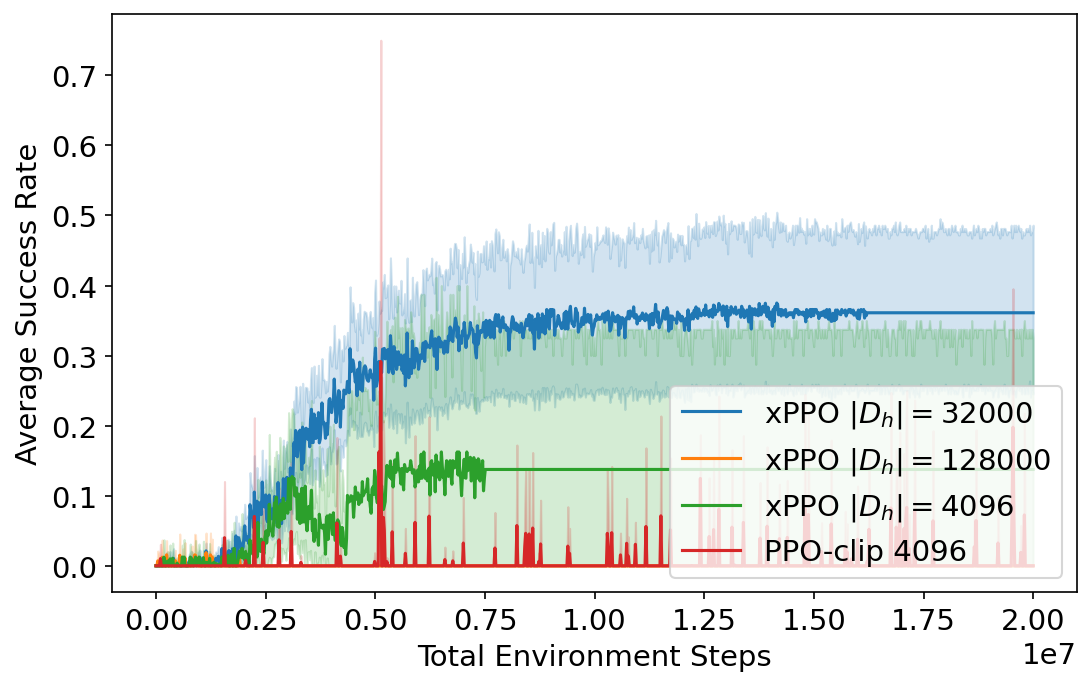

In [23]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Average Success Rate",
    hue="Algorithm",
    ci=95,
    # style="Environment",
    # palette="viridis",
)
plt.legend(loc="lower right")
# plt.legend(loc='upper left', bbox_to_anchor=(0.90, 1),
#           ncol=1, fancybox=True, shadow=True, fontsize=13)
plt.tight_layout()
plt.savefig(f"historical_buffer_sweep_{env}.pdf")


## Window Open

In [10]:

env = 'WindowOpen'
config_env = "<SawyerWindowOpenEnvV2 instance>"
total_steps = 3e6
group_and_keys = [
    ("xppo_single_step_4096", "global_step",  "rollout/SuccessRate"),
    ("xppo_single_step_large_historic", "global_step", "rollout/SuccessRate"),
    ('xppo_single_step_no_historic', "global_step", "rollout/SuccessRate"),
    ("basline_stbl_ppo", "global_step", "rollout/SuccessRate"),
]

tag_filter = {"tags": {"$in": ["stbl_ppo_pick-place_baseline"]}}
group_filter = {"group": {"$in": ["xppo_single_step_4096", "xppo_single_step_large_historic", 'xppo_single_step_no_historic']}} # to not exclude not yet tagged runs
env_filter = {"config.env":config_env}
or_filter = {"$or": [tag_filter, {"$and": [group_filter,env_filter]}]}

state_filter = {"$or": [{"state": "finished"}, {"state": "running"}]}

extra_filter = {'$and': [ state_filter, or_filter]}

all_data = load_groups(
    group_and_keys,
    relabels,
    (0, total_steps),
    extra_filter
)

Got 6 runs for group xppo_single_step_4096


100%|██████████| 6/6 [00:02<00:00,  2.19it/s]


Got 7 runs for group xppo_single_step_large_historic


100%|██████████| 7/7 [00:02<00:00,  2.69it/s]


Got 0 runs for group xppo_single_step_no_historic


0it [00:00, ?it/s]


Got 3 runs for group basline_stbl_ppo


100%|██████████| 3/3 [00:06<00:00,  2.12s/it]


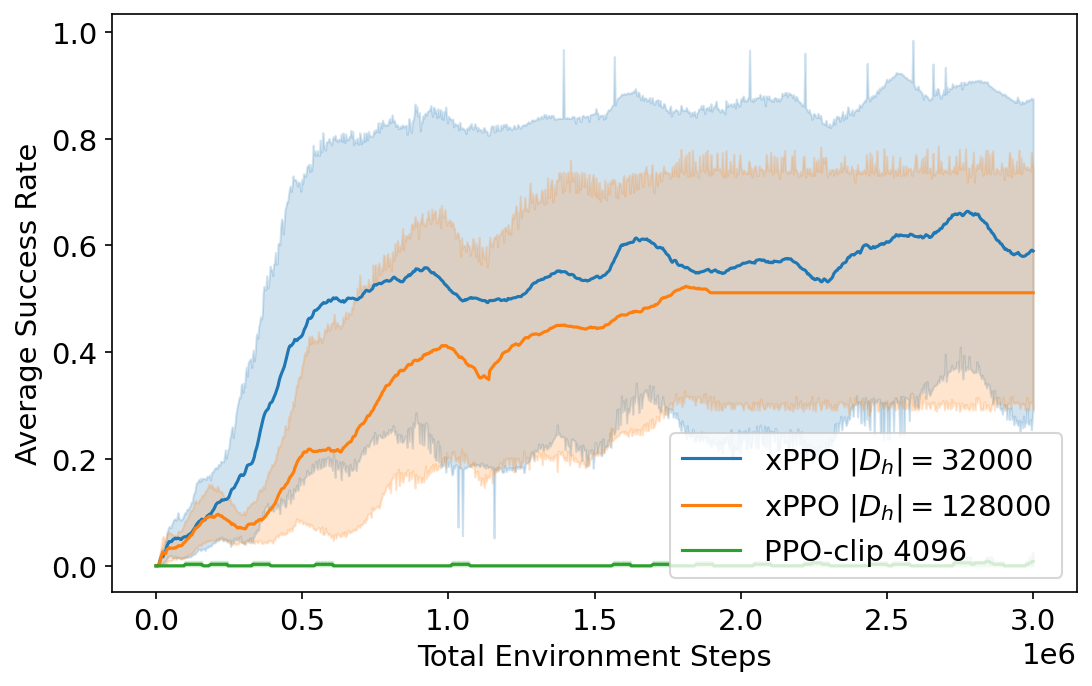

In [11]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Average Success Rate",
    hue="Algorithm",
    ci=95,
    # style="Environment",
    # palette="viridis",
)
plt.legend(loc="lower right")
# plt.legend(loc='upper left', bbox_to_anchor=(0.90, 1),
#           ncol=1, fancybox=True, shadow=True, fontsize=13)
plt.tight_layout()
plt.savefig(f"historical_buffer_sweep_{env}.pdf")


## Reach

In [12]:

env = 'Reach'
config_env = "<SawyerReachEnvV2 instance>"
total_steps = 3e6
group_and_keys = [
    ("xppo_single_step_4096", "global_step",  "rollout/SuccessRate"),
    ("xppo_single_step_large_historic", "global_step", "rollout/SuccessRate"),
    ('xppo_single_step_no_historic', "global_step", "rollout/SuccessRate"),
    ("basline_stbl_ppo", "global_step", "rollout/SuccessRate"),
]

tag_filter = {"tags": {"$in": ["stbl_ppo_pick-place_baseline"]}}
group_filter = {"group": {"$in": ["xppo_single_step_4096", "xppo_single_step_large_historic", 'xppo_single_step_no_historic']}} # to not exclude not yet tagged runs
env_filter = {"config.env":config_env}
or_filter = {"$or": [tag_filter, {"$and": [group_filter,env_filter]}]}

state_filter = {"$or": [{"state": "finished"}, {"state": "running"}]}

extra_filter = {'$and': [ state_filter , or_filter]}

all_data = load_groups(
    group_and_keys,
    relabels,
    (0, total_steps),
    extra_filter
)

Got 5 runs for group xppo_single_step_4096


100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


Got 8 runs for group xppo_single_step_large_historic


100%|██████████| 8/8 [00:02<00:00,  3.55it/s]


Got 0 runs for group xppo_single_step_no_historic


0it [00:00, ?it/s]


Got 3 runs for group basline_stbl_ppo


100%|██████████| 3/3 [00:06<00:00,  2.16s/it]


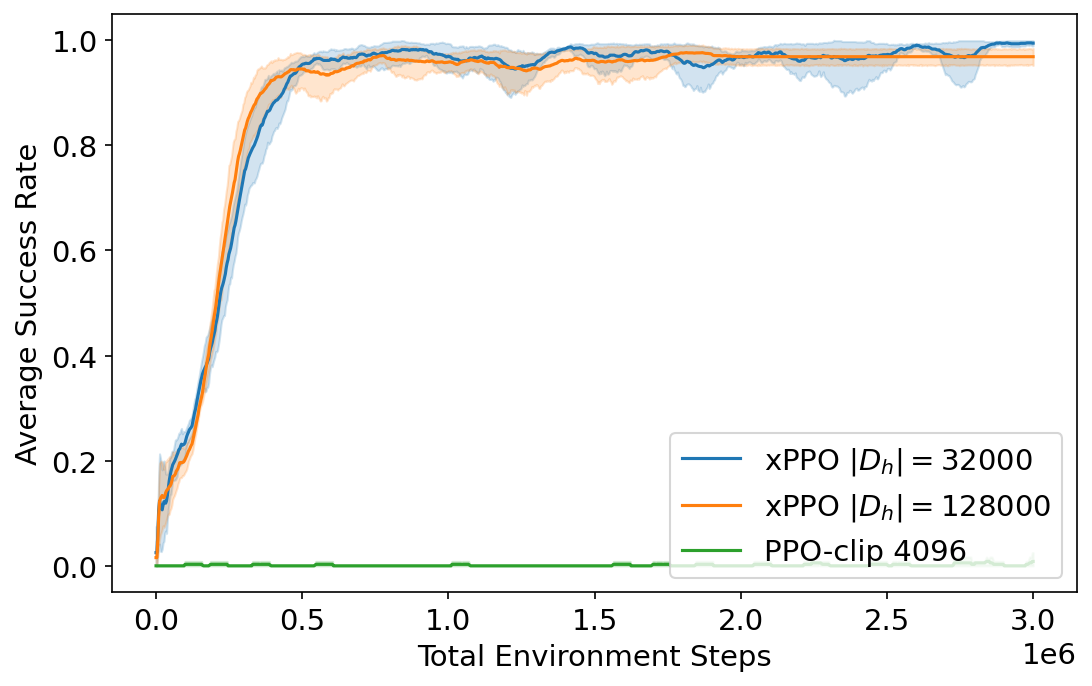

In [13]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Average Success Rate",
    hue="Algorithm",
    ci=95,
    # style="Environment",
    # palette="viridis",
)
plt.legend(loc="lower right")
# plt.legend(loc='upper left', bbox_to_anchor=(0.90, 1),
#           ncol=1, fancybox=True, shadow=True, fontsize=13)
plt.tight_layout()
plt.savefig(f"historical_buffer_sweep_{env}.pdf")
